In [16]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import cohen_kappa_score, confusion_matrix,ConfusionMatrixDisplay
from xgboost import XGBRegressor

# !pip install pgeocode

# import pgeocode

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# 데이터 경로
path = '/content/drive/MyDrive/모듈프젝2/A팀-회귀/data/playground-series-season-3-episode-6/'

train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
original = pd.read_csv(path + 'ParisHousing.csv')
original = original.reset_index()
original['id'] = original['index'] + 1000000
original = original.drop(columns = ['index'])
train.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


In [19]:
original.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,id
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5,1000000
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5,1000001
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1,1000002
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2,1000003
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0,1000004


In [20]:
print(len(train))
print(len(test))
print(len(original))

22730
15154
10000


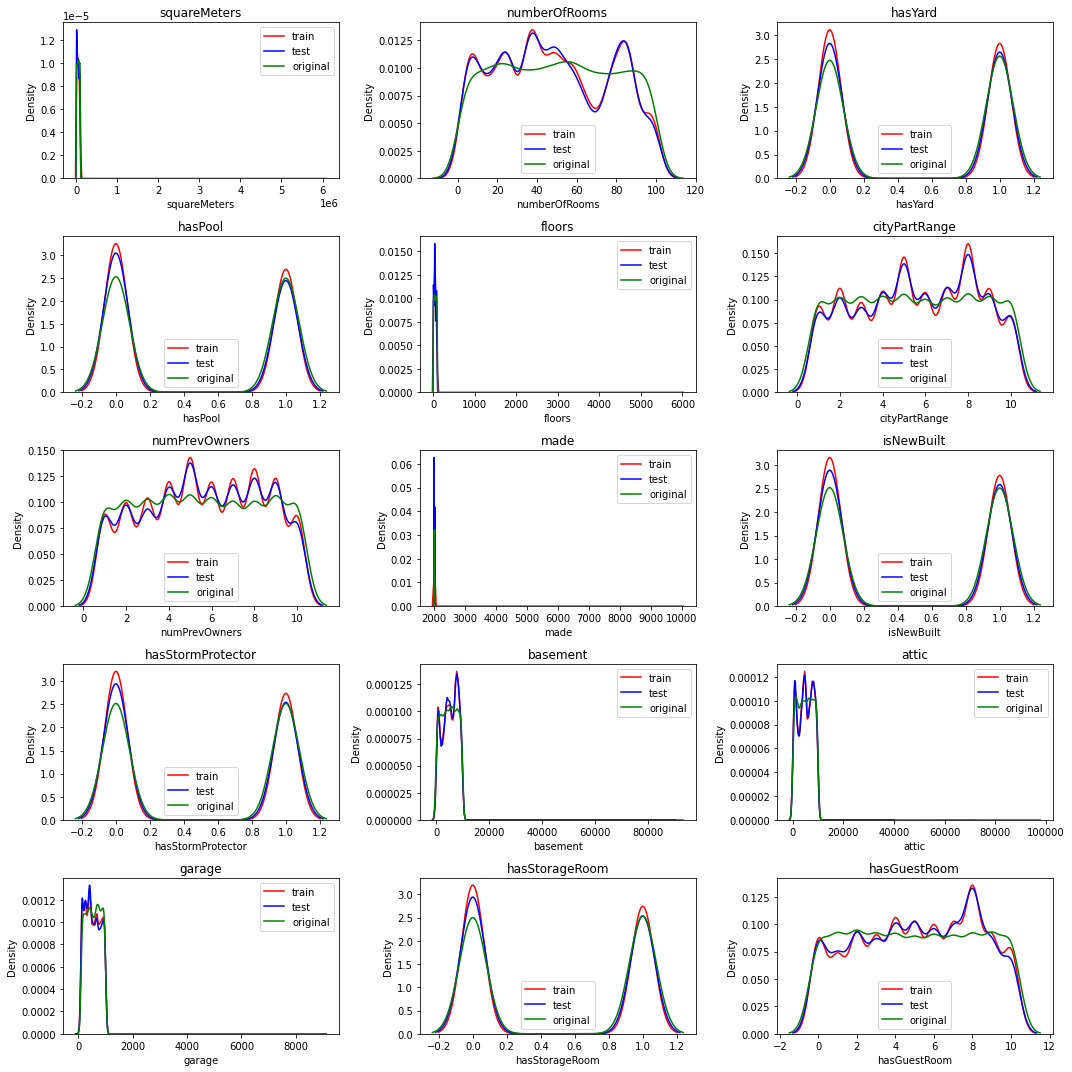

In [21]:
ncols = 3
nrows = int(np.ceil(len(num_cols)/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
for ax, f in zip(axes.flat, num_cols):
    sns.kdeplot(train[f], color='r', label='train', ax=ax)
    sns.kdeplot(test[f], color='b', label='test', ax=ax)
    sns.kdeplot(original[f], color='g', label='original', ax=ax)
    ax.set_title(f)
    ax.legend()
plt.tight_layout()
plt.show()

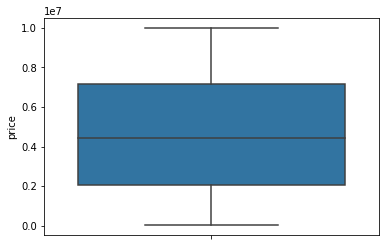

In [22]:
sns.boxplot(y = 'price',data = train)

In [23]:
# eiffel_zip = '75007'
# dist = pgeocode.GeoDistance('fr')
# train['Dist_From_Eiffel'] = train['cityCode'].apply(lambda x: dist.query_postal_code(eiffel_zip , x))

# nomi = pgeocode.Nominatim('fr')
# cols = ['place_name','state_name','state_code','latitude','longitude']

# train[cols] = train.apply(lambda row: nomi.query_postal_code(row['cityCode'])[cols], axis=1, result_type='expand')
# train.head()

# original[cols] = original.apply(lambda row: nomi.query_postal_code(row['cityCode'])[cols], axis=1, result_type='expand')
# original.head()

# made

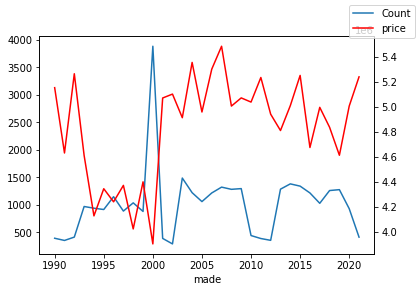

In [75]:
made = pd.DataFrame(train.groupby(['made']).size()).reset_index().rename(columns = {0:'Count'})
made = made[made['made']< 5000]

made1 = pd.DataFrame(train.groupby(['made'])['price'].mean()).reset_index().rename(columns = {0:'mean_price'})

made = pd.merge(made,made1, on = 'made', how = 'inner')

ax = made.plot(x="made", y="Count", legend=False)
ax2 = ax.twinx()
made.plot(x="made", y="price", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

In [76]:
train = pd.concat([train,original])

In [77]:
train_1 = train[train['made']<=2000]
test_1 = test[test['made']<=2000]
train_2 = train[(train['made']>=2001) & (train['made']<=2007)]
test_2 = test[(test['made']>=2001) & (test['made']<=2007)]
train_3 = train[train['made']>2007]
test_3 = test[test['made']>2007]

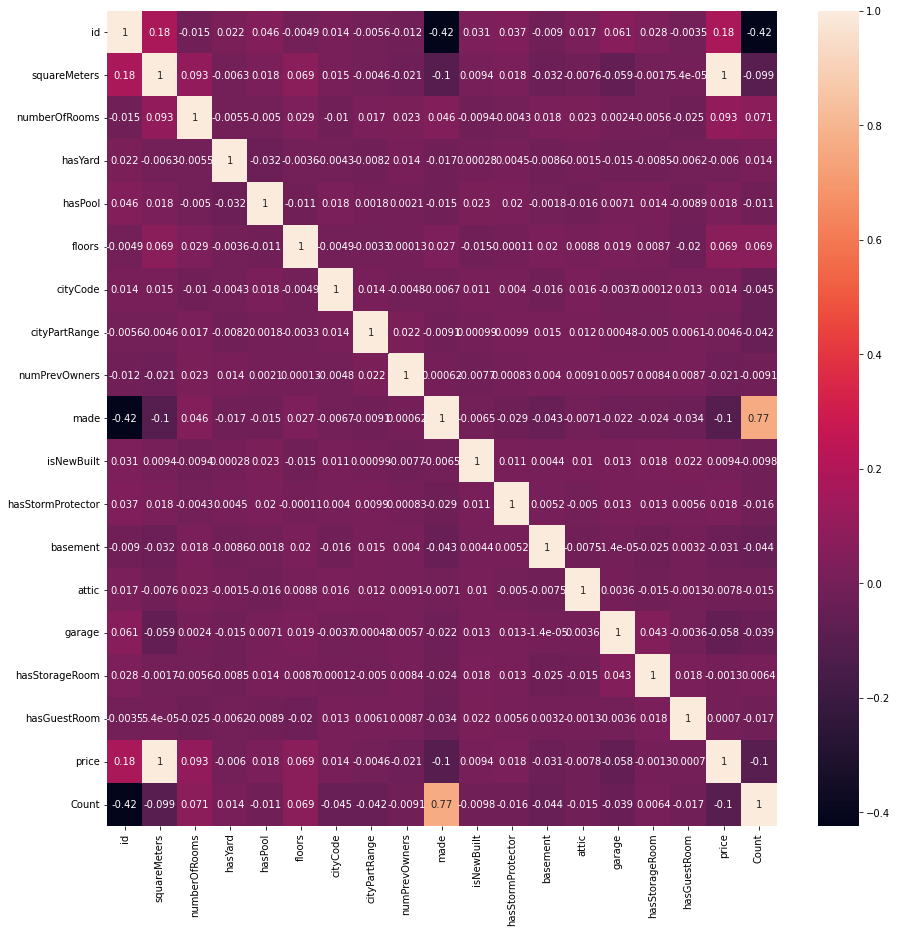

In [78]:
train_1 = pd.merge(train_1,made[['made','Count']], on = 'made', how = 'inner')
test_1 = pd.merge(test_1,made[['made','Count']], on = 'made', how = 'inner')
plt.figure(figsize=(15,15))
sns.heatmap(train_1.corr(),annot=True)
# plt.savefig("Heatmap.png")
plt.show()

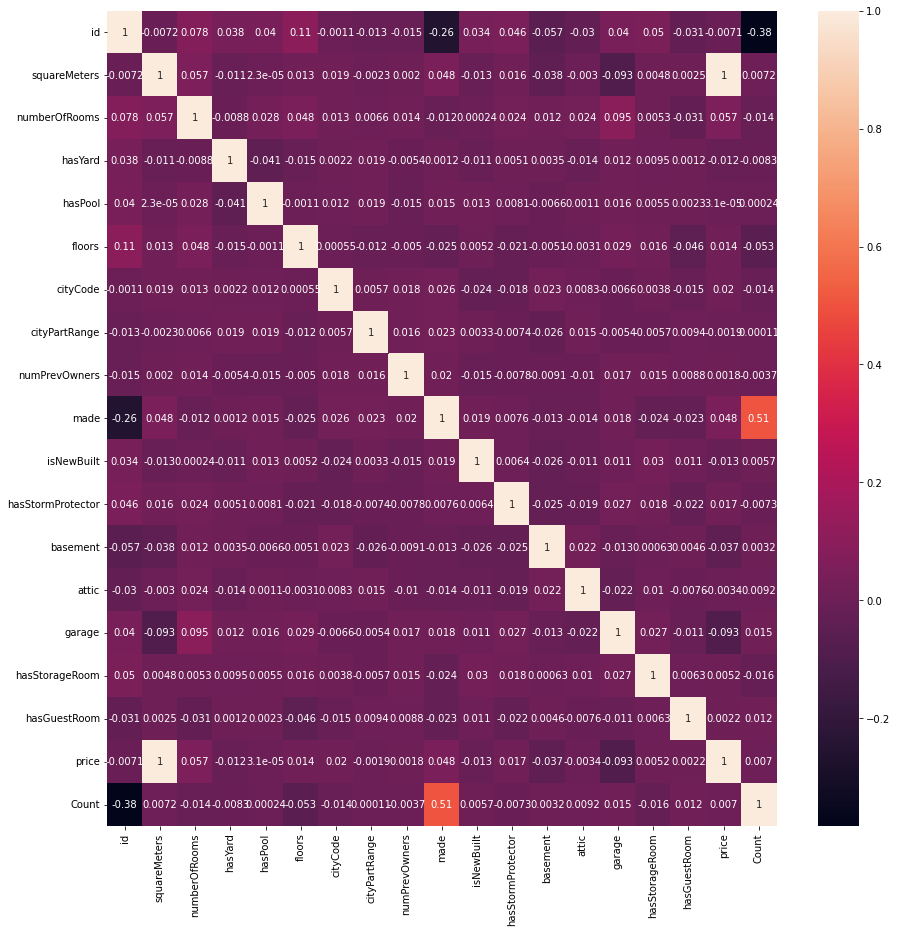

In [79]:
train_2 = pd.merge(train_2,made[['made','Count']], on = 'made', how = 'inner')
test_2 = pd.merge(test_2,made[['made','Count']], on = 'made', how = 'inner')
plt.figure(figsize=(15,15))
sns.heatmap(train_2.corr(),annot=True)
# plt.savefig("Heatmap.png")
plt.show()

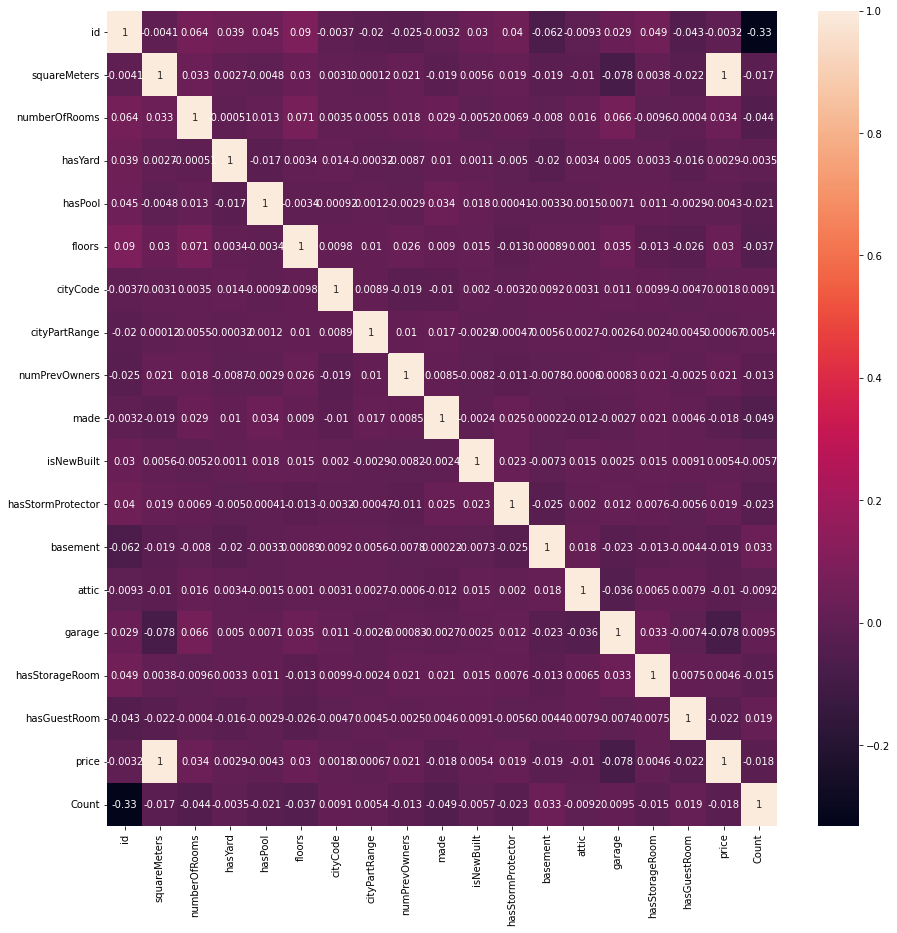

In [80]:
train_3 = pd.merge(train_3,made[['made','Count']], on = 'made', how = 'inner')
test_3 = pd.merge(test_3,made[['made','Count']], on = 'made', how = 'inner')
plt.figure(figsize=(15,15))
sns.heatmap(train_3.corr(),annot=True)
# plt.savefig("Heatmap.png")
plt.show()

In [96]:
num_cols = ['squareMeters', 'numberOfRooms', 'floors', 'cityCode', 'made', 'basement', 'attic', 'garage' ]

In [97]:
num_cols = num_cols + ['Count']

In [98]:
X1 = train_1[num_cols]
# X1 = train_1[['squareMeters']]
y1 = train_1['price']

model=XGBRegressor(max_depth=3, learning_rate=0.24 , n_estimators=2000, objective='reg:linear', booster='gbtree')
XGB=model.fit(X1,y1)


X_test = test_1[num_cols]
# X_test = test_1[['squareMeters']]
prediction=XGB.predict(X_test)

test_1['price'] = prediction
test_1

[05:11:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,Count,price
0,22730,47580,89,0,1,8,54830,5,3,1995,0,0,6885,8181,241,0,8,916,4758646.000
1,22751,69856,47,0,1,26,75382,1,8,1995,1,0,17,853,854,1,8,916,6992329.000
2,22755,23608,51,0,0,31,50452,10,6,1995,1,0,6410,8153,945,1,8,916,2365589.000
3,22775,67724,11,1,1,64,7207,2,10,1995,0,1,7448,1932,128,1,2,916,6775894.500
4,22815,50778,39,0,1,94,19117,2,1,1995,0,0,5294,7178,614,0,2,916,5082967.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5584,35303,84696,45,0,0,14,77081,7,4,1991,0,1,8681,5246,524,1,6,354,8470514.000
5585,35522,42630,34,0,1,25,43807,9,7,1991,1,0,7976,331,236,0,0,354,4266115.000
5586,35686,18316,20,0,1,5,50693,2,6,1991,0,0,6574,2166,127,1,5,354,1833195.125
5587,36267,41700,48,0,1,8,46266,5,7,1991,0,0,743,7716,194,1,2,354,4178366.750


In [99]:
X2 = train_2[num_cols]
# X2 = train_2[['squareMeters']]
y2 = train_2['price']

model=XGBRegressor(max_depth=3, learning_rate=0.24 , n_estimators=2000, objective='reg:linear', booster='gbtree')
XGB=model.fit(X2,y2)

X_test = test_2[num_cols]
# X_test = test_2[['squareMeters']]
prediction=XGB.predict(X_test)

test_2['price'] = prediction
test_2

[05:11:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,Count,price
0,22740,69567,38,0,0,11,8824,8,3,2003,0,1,8194,8627,124,0,3,1488,6.969627e+06
1,22776,15351,34,0,0,10,95917,3,6,2003,0,0,6341,5844,929,1,6,1488,1.541402e+06
2,22868,4198,6,1,0,80,75722,3,8,2003,0,0,3795,4194,885,1,8,1488,4.228010e+05
3,22887,62064,86,1,1,35,6769,2,3,2003,1,0,8000,2600,976,0,10,1488,6.200202e+06
4,22907,91618,4,0,0,36,70160,8,3,2003,1,1,6484,2731,121,1,5,1488,9.154990e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225,36015,73748,84,0,0,32,55523,5,2,2001,1,1,4309,7379,273,1,9,391,7.379109e+06
3226,36030,90170,63,1,1,20,16798,9,5,2001,1,0,4196,2528,945,1,3,391,9.022202e+06
3227,36156,41700,8,0,0,64,51294,7,9,2001,1,0,8163,8153,194,0,8,391,4.176994e+06
3228,36298,55620,61,1,1,90,80933,3,4,2001,1,1,9867,7179,548,0,1,391,5.576670e+06


In [100]:
X3 = train_3[num_cols]
y3 = train_3['price']

model=XGBRegressor(max_depth=3, learning_rate=0.24 , n_estimators=2000, objective='reg:linear', booster='gbtree')
XGB=model.fit(X3,y3)

X_test = test_3[num_cols]
prediction=XGB.predict(X_test)

test_3['price'] = prediction
test_3

[05:11:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,Count,price
0,22733,16354,47,1,1,9,9262,6,5,2019,1,1,705,5097,122,1,5,1277,1649981.375
1,22748,35423,52,1,1,24,40954,6,8,2019,1,0,8486,4375,489,1,5,1277,3559740.750
2,22820,85256,74,0,1,39,92707,1,1,2019,0,1,3945,5240,745,1,0,1277,8529500.000
3,22826,68847,74,1,1,80,72028,10,6,2019,0,1,9789,9476,847,1,5,1277,6888392.000
4,22840,15815,13,1,1,7,95518,7,3,2019,1,1,2494,8575,827,1,5,1277,1582287.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6330,36857,54484,38,1,1,78,5324,8,6,2011,0,1,8235,8136,114,1,8,389,5457988.000
6331,37118,54484,25,1,0,94,8235,4,5,2011,0,1,8163,8889,241,0,6,389,5460536.000
6332,37278,27949,84,1,0,94,86189,5,9,2011,1,1,8578,9248,245,1,1,389,2942900.000
6333,37431,76932,85,0,1,89,1529,5,4,2011,0,0,8767,8149,583,1,0,389,7682104.000


In [101]:
submission = pd.concat([test_1,test_2,test_3])
submission = submission[['id','price']]
submission = submission.sort_values(by = ['id'])
submission.to_csv('submission.csv',index = False)
submission.head()

,id,price
0,22730,4758646.000
402,22731,6221473.000
827,22732,9052042.000
0,22733,1649981.375
685,22734,6764307.500
